# Chapter: Dimension Reduction and Latent Variable Methods (Part 2)¶¶

# Topic: Process Monitoring via PCA

In [7]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          ICA model for TEP data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [24]:
# import required packages
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [25]:
# fetch TE data
TEdata_noFault_train = np.loadtxt('d00.dat').T # data arrnagement in d00.dat is different than that in other files

# select variables as done in Lee et al.
xmeas = TEdata_noFault_train[:,0:22]
xmv = TEdata_noFault_train[:,41:52]
data_noFault_train = np.hstack((xmeas, xmv))

In [26]:
# scale data
scaler = StandardScaler()
data_train_normal = scaler.fit_transform(data_noFault_train)

In [28]:
# decide # of ICs to retain via PCA variance method and compute ICs
pca = PCA().fit(data_train_normal)

explained_variance = 100*pca.explained_variance_ratio_ # in percentage
cum_explained_variance = np.cumsum(explained_variance) # cumulative % variance explained

n_comp = np.argmax(cum_explained_variance >= 90) + 1

In [13]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                     Monitoring statistics function
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [29]:
def compute_PCA_monitoring_metrics(pca_model, number_comp, data):
    """ calculate monitoring statistics for given data 
    
    parameters
    -----------
    data: numpy array of shape = [n_samples, n_features]
          Training or test data
    
    Returns
    ----------
    monitoring_stats: numpy array of shape = [n_samples, 2]
        
    """
    
    # data parameters
    n = data.shape[0]
    
    # model parameters
    V_matrix = pca.components_.T
    P_matrix = V_matrix[:,0:n_comp] 
    
    # model computation
    score = pca.transform(data)
    score_reduced = score[:,0:n_comp] 
    data_reconstruct = np.dot(score_reduced, P_matrix.T)

    # T2
    lambda_k = np.diag(pca.explained_variance_[0:n_comp])
    lambda_k_inv = np.linalg.inv(lambda_k)    
    T2 = np.zeros((data.shape[0],))
    for i in range(n):
        T2[i] = np.dot(np.dot(score_reduced[i,:],lambda_k_inv),score_reduced[i,:].T)
        
    # SPE
    error = data - data_reconstruct
    SPE = np.sum(error*error, axis = 1)
    
    monitoring_stats = np.column_stack((T2, SPE))
    return monitoring_stats


In [30]:
def draw_monitoring_chart(values, CL, yLabel):
    plt.figure()
    plt.plot(values)
    plt.axhline(CL, color = "red", linestyle = "--")
    plt.xlabel('Sample #')
    plt.ylabel(yLabel)
    plt.show()

def draw_PCA_monitoring_charts(PCA_statistics, CLs, trainORtest):
    """ draw monitoring charts for given data 
    
    parameters
    -----------
    PCA_statistics: numpy array of shape = [n_samples, 2]
    CLs: List of control limits
    trainORtest: 'training' or 'test'

    """
    
    # T2 chart, SPE chart
    draw_monitoring_chart(PCA_statistics[:,0], CLs[0], 'T2 for ' + trainORtest + ' data') 
    draw_monitoring_chart(PCA_statistics[:,1], CLs[1], 'SPE for ' + trainORtest + ' data')

In [16]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                   Draw monitoring charts for training data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

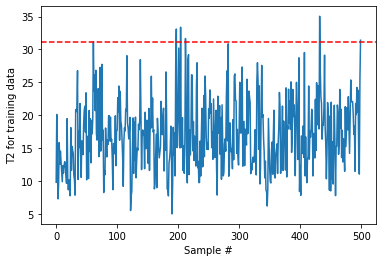

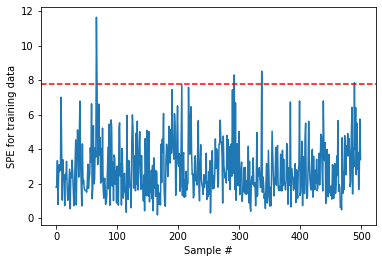

In [31]:
PCA_statistics_train = compute_PCA_monitoring_metrics(pca, n_comp, data_train_normal)

T2_CL = np.percentile(PCA_statistics_train[:,0], 99)
SPE_CL = np.percentile(PCA_statistics_train[:,1], 99)

draw_PCA_monitoring_charts(PCA_statistics_train, [T2_CL, SPE_CL], 'training')

In [18]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                   FAR / FDR computation function
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [19]:
def compute_alarmRate(monitoring_stats, CLs):
    """ calculate alarm rate 
    
    parameters
    -----------
    monitoring_stats: numpy array of shape = [n_samples, 2]
    CLs: List of control limits
    
    Returns
    ----------
    alarmRate: float
        
    """
    
    violationFlag = monitoring_stats > CLs 
    alarm_overall = np.any(violationFlag, axis=1) # violation of any metric => alarm
    alarmRate = 100*np.sum(alarm_overall)/monitoring_stats.shape[0]
    
    return alarmRate

In [20]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                   Draw monitoring charts for test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

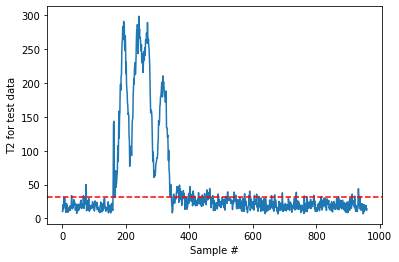

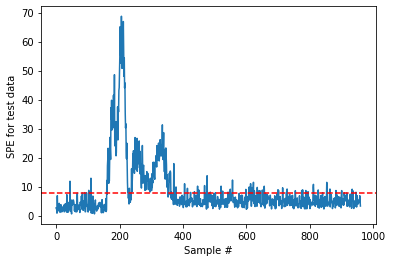

In [32]:
# fetch data
TEdata_Fault_test = np.loadtxt('d05_te.dat')

# select data as done in Lee et al.
xmeas = TEdata_Fault_test[:,0:22]
xmv = TEdata_Fault_test[:,41:52]
data_Fault_test = np.hstack((xmeas, xmv))
         
# scale data
data_test_scaled = scaler.transform(data_Fault_test)

# compute statistics and draw charts
PCA_statistics_test = compute_PCA_monitoring_metrics(pca, n_comp, data_test_scaled)
draw_PCA_monitoring_charts(PCA_statistics_test, [T2_CL, SPE_CL], 'test')

In [33]:
# compute FAR or FDR
alarmRate = compute_alarmRate(PCA_statistics_test[160:,:], [T2_CL, SPE_CL]) # faults start from sample 160
print(alarmRate)

41.5
